In [1]:
import torch
import wandb
import os

from inference.bayesian.models import TorchModel
# from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

import pyro

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [50, 10, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "inference": "q_regr",
            "lr": 0.03,
            "num_iterations": 120,
            "quantile": 0.95,
            "plot": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
Ytr, train_embedding, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 4882, Val: 1047, Te: 1047


# Quantile Regression

In [5]:
QR_torch_model = TorchModel(config.model_widths, config.activation).to(device)

In [6]:
predictive, diagnostics = inference(config, QR_torch_model, None, X_train=train_embedding, Y_train=Ytr, X_test=test_embedding, Y_test=Yte, num_samples=None)

[iteration 0001] loss: 1.2753
[iteration 0021] loss: 6.7512
[iteration 0041] loss: 6.7295
[iteration 0061] loss: 6.7510
[iteration 0081] loss: 6.7588
[iteration 0101] loss: 6.7395


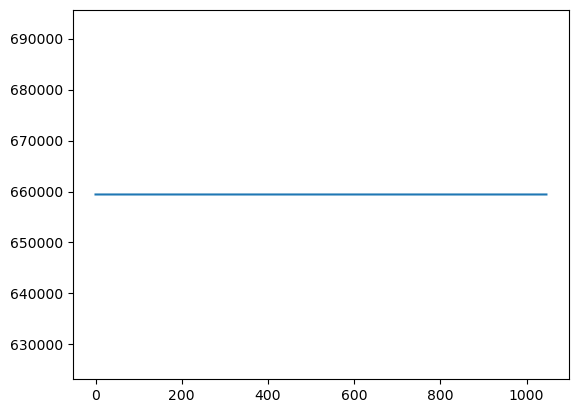

In [10]:
import matplotlib.pyplot as plt

plt.plot(predictive.detach().cpu().numpy())

testing

https://github.com/ceshine/quantile-regression-tensorflow/blob/master/notebooks/03-sklearn-example-pytorch.ipynb

In [11]:
import numpy as np

In [12]:
model = QR_torch_model

In [18]:
def qloss(preds, target, quantiles):
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

In [23]:
epochs = 1000
batch_size = 10

model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

x = train_embedding
y = Ytr

for e in range(epochs):
    # shuffle_idx = np.arange(x.shape[0])
    # np.random.shuffle(shuffle_idx)
    # x = x[shuffle_idx]
    # y = y[shuffle_idx]
    epoch_losses = []
    for idx in range(0, x.shape[0], batch_size):
        optimizer.zero_grad()
        batch_x = x[idx : min(idx + batch_size, x.shape[0]),:].requires_grad_(False)
        batch_y = y[idx : min(idx + batch_size, y.shape[0])].requires_grad_(False)
        preds = model(batch_x)
        loss = qloss(preds, batch_y, [0.5])
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.cpu().detach().numpy())                                
    epoch_loss =  np.mean(epoch_losses)
    if (e+1) % 100 == 0:
        print("Epoch {}: {}".format(e+1, epoch_loss))

Epoch 100: 357.9814147949219
Epoch 200: 357.7261047363281
Epoch 300: 357.46673583984375
Epoch 400: 357.2109680175781
Epoch 500: 356.9507751464844
Epoch 600: 356.6938171386719
Epoch 700: 356.432861328125
Epoch 800: 356.1772766113281
Epoch 900: 355.9187927246094
Epoch 1000: 355.6596984863281


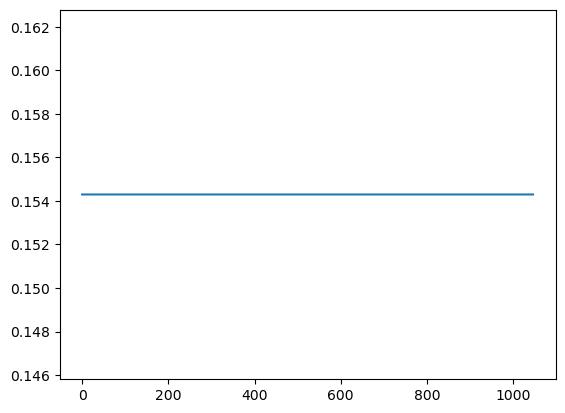

In [24]:
pred = model(test_embedding)

plt.plot(pred.detach().cpu().numpy())